In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

rf_rates = pd.read_csv('TB3MS.csv')

# it is giving diff rows every time,
# every time rows are increasing, maybe due to some limits of colab
NUM_ROWS = 5000000
NUM_ROWS_5M = 5000000
NUM_ROWS_600k = 600000
NUM_ROWS_1M = 1000000
df = pd.read_csv('crspm_and_predictors.csv')
df = df.sort_values(by='yyyymm', ascending=False).head(NUM_ROWS_1M) # decreasing order
df.shape # (500000, 119)

rf_rates['observation_date'] = pd.to_datetime(rf_rates['observation_date'], format='%Y-%m-%d')
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m') #df.loc[:, 'yyyymm']

# need to be changed according to data
filtered_tb3ms = rf_rates[(rf_rates['observation_date'] >= '1990-01-01') &
                          (rf_rates['observation_date'] <= '2024-12-01')]
filtered_tb3ms.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)


#########################################################################################################
# Merge the DataFrames based on the date columns
merged_df = pd.merge(df, filtered_tb3ms, left_on='yyyymm',
                        right_on='observation_date', how='left')
merged_df.drop(columns=['observation_date'], inplace=True)
merged_df.rename(columns={'TB3MS': 'RiskFree', 'yyyymm': 'date'}, inplace=True)
merged_df = merged_df.replace({-np.inf: np.nan, np.inf: np.nan})
print(f'after rename {merged_df.shape}')



non_nan_col = merged_df[['permno', 'date']].copy()
numeric_df = merged_df.drop(columns=['permno', 'date']).fillna(0)
features_df = merged_df.drop(columns=['permno', 'date', 'prc', 'Price', 'ret', 'RiskFree'])
print(features_df.shape)

merged_df = pd.concat([non_nan_col, numeric_df], axis=1)
print(f'after concat {merged_df.shape}')

#########################################################################################################
df_all_cols = merged_df.copy()
df_all_cols['ExcessReturn'] = df_all_cols['ret'] - df_all_cols['RiskFree']
df_all_cols = df_all_cols.sort_values(by='date', ascending=True).reset_index(drop=True)

df_all_cols_copy = df_all_cols.copy()



after rename (1000000, 120)
(1000000, 114)
after concat (1000000, 120)


In [43]:
DATE_COL = 'date'
df_all_cols[DATE_COL]

0        2015-04-01
1        2015-04-01
2        2015-04-01
3        2015-04-01
4        2015-04-01
            ...    
999995   2024-12-01
999996   2024-12-01
999997   2024-12-01
999998   2024-12-01
999999   2024-12-01
Name: date, Length: 1000000, dtype: datetime64[ns]

In [48]:
# time aware summary 

train_date_max = '2022-01-01'
val_date_max = '2023-01-01'
test_date_min = '2025-01-01'
DATE_COL = 'date'
date_col = df_all_cols[DATE_COL]
# Define splits
print(df_all_cols.shape)
print(f'Df Data summary isIncreasing { date_col.is_monotonic_increasing} df shape {df.shape}')
train_df = df_all_cols[date_col < train_date_max]
val_df = df_all_cols[(date_col >= train_date_max) & (date_col < val_date_max)]
test_df = df_all_cols[date_col >= val_date_max]

# Create summary table
split_summary = {
    "Train Set": [train_df[DATE_COL].min(), train_df[DATE_COL].max(), len(train_df)],
    "Validation Set": [val_df[DATE_COL].min(), val_df[DATE_COL].max(), len(val_df)],
    "Test Set": [test_df[DATE_COL].min(), test_df[DATE_COL].max(), len(test_df)]
}

# Format into DataFrame
split_df = pd.DataFrame(split_summary, index=["Start Date", "End Date", "Row Count"]).T

print(f'min data {date_col.min()} max date {date_col.max()}')
# Show the table
print(split_df)


(1000000, 121)
Df Data summary isIncreasing True df shape (1000000, 119)
min data 2015-04-01 00:00:00 max date 2024-12-01 00:00:00
                         Start Date             End Date Row Count
Train Set       2015-04-01 00:00:00  2021-12-01 00:00:00    642397
Validation Set  2022-01-01 00:00:00  2022-12-01 00:00:00    118905
Test Set        2023-01-01 00:00:00  2024-12-01 00:00:00    238698


## initial attempt at identifying potential outliers


Following were flagged as potential outliers from previous analysis, we are going to plot boxplots and histplots for these variables

| Variable        | Why it stood out                                                                 |
|----------------|-----------------------------------------------------------------------------------|
| `ret`          | Range from -100 to +550 — unusually wide for returns                             |
| `EarnSupBig`   | Max over 10¹³ — likely a data error or outlier                                   |
| `EarningsSurprise` | Max over 10¹⁶ — clearly an extreme value                                      |
| `Price`        | Negative prices + very high max                                                  |
| `PctTotAcc`    | Long-tailed distribution — wide range                                            |
| `CBOperProf`   | Value goes below -2 and above 1.4 — wide spread                                  |



### you can see that ReturnSkew3F and ReturnSkew are highly correlated we can drop one of them before modelling 

In [50]:
from tabulate import tabulate

# number of rows 
print(f"Number of Rows and columns in the dataset {df.shape}")
price_cols = ['ret', 'prc', 'Price']
subset_df = df[price_cols]


summary = {
    "Column Name": subset_df.columns,
    "Data Type": subset_df.dtypes.values,
    "Missing Values": subset_df.isnull().sum().values,
    "Unique Values": subset_df.nunique().values,
    "Mean": subset_df.mean(numeric_only=True).values,
    "Median": subset_df.median(numeric_only=True).values,
    "Std Dev": subset_df.std(numeric_only=True).values,  # Standard deviation
    #"Skewness": df.skew(numeric_only=True).values,  # Detects skewed distributions
    #"Kurtosis": df.kurt(numeric_only=True).values,  # Detects extreme outliers
    #"Correlation with Target": df.corr()[CREDIT_DEFAULT_STATUS].values  # Feature relevance check
}
    
summary_df = pd.DataFrame(summary)
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid"))

Number of Rows and columns in the dataset (1000000, 119)
╒════╤═══════════════╤═════════════╤══════════════════╤═════════════════╤══════════╤══════════╤════════════╕
│    │ Column Name   │ Data Type   │   Missing Values │   Unique Values │     Mean │   Median │    Std Dev │
╞════╪═══════════════╪═════════════╪══════════════════╪═════════════════╪══════════╪══════════╪════════════╡
│  0 │ ret           │ float64     │            53401 │          343869 │  0.50524 │  0.2962  │   18.8347  │
├────┼───────────────┼─────────────┼──────────────────┼─────────────────┼──────────┼──────────┼────────────┤
│  1 │ prc           │ float64     │            50089 │          138233 │ 83.7995  │ 21.75    │ 4357.94    │
├────┼───────────────┼─────────────┼──────────────────┼─────────────────┼──────────┼──────────┼────────────┤
│  2 │ Price         │ float64     │            50089 │          130797 │ -2.90727 │ -3.11654 │    1.35617 │
╘════╧═══════════════╧═════════════╧══════════════════╧════════════════

In [51]:

df_all_cols['MarketReturn'] = df_all_cols.groupby('date')['ret'].transform('mean')
df_all_cols['MarketExcessReturn'] = df_all_cols['MarketReturn'] - df_all_cols['RiskFree']
df_all_cols.sort_values('date', inplace=True)
df_market_return = df_all_cols[['date', 'MarketReturn']].drop_duplicates().reset_index(drop=True)

df_all_cols.reset_index(drop=True, inplace=True)
df_all_cols

,permno,date,prc,ret,Price,...,CBOperProf,RiskFree,ExcessReturn,MarketReturn,MarketExcessReturn
0,91138,2015-04-01,14.21000,0.7032,-2.653946,...,0.000000,0.02,0.6832,2.158843,2.138843
1,86580,2015-04-01,22.19500,6.0693,-3.099867,...,0.290221,0.02,6.0493,2.158843,2.138843
2,91227,2015-04-01,167.96001,-2.5867,-5.123726,...,0.000000,0.02,-2.6067,2.158843,2.138843
3,15154,2015-04-01,25.10000,-0.8101,-3.222868,...,0.000000,0.02,-0.8301,2.158843,2.138843
4,86573,2015-04-01,24.85000,2.8134,-3.212858,...,0.000000,0.02,2.7934,2.158843,2.138843
...,...,...,...,...,...,...,...,...,...,...,...
999995,23052,2024-12-01,0.48500,25.0000,0.723606,...,0.000000,4.27,20.7300,-2.245105,-6.515105
999996,78405,2024-12-01,30.73000,-13.0301,-3.425239,...,0.000000,4.27,-17.3001,-2.245105,-6.515105
999997,82598,2024-12-01,116.08000,-5.3490,-4.754280,...,0.000000,4.27,-9.6190,-2.245105,-6.515105
999998,15371,2024-12-01,28.65000,-6.0656,-3.355153,...,0.000000,4.27,-10.3356,-2.245105,-6.515105


In [52]:

df_all_cols_copy['MarketReturn'] = df_all_cols_copy.groupby('date')['ret'].transform('mean')
df_all_cols_copy['MarketExcessReturn'] = df_all_cols_copy['MarketReturn'] - df_all_cols_copy['RiskFree']
df_all_cols_copy.sort_values('date', inplace=True)
df_market_return = df_all_cols_copy[['date', 'MarketReturn']].drop_duplicates().reset_index(drop=True)

df_all_cols_copy.reset_index(drop=True, inplace=True)
df_all_cols_copy

,permno,date,prc,ret,Price,...,CBOperProf,RiskFree,ExcessReturn,MarketReturn,MarketExcessReturn
0,91138,2015-04-01,14.2100,0.7032,-2.653946,...,0.000000,0.02,0.6832,2.158843,2.138843
1,87302,2015-04-01,4.2300,-9.8081,-1.442202,...,0.048983,0.02,-9.8281,2.158843,2.138843
2,12579,2015-04-01,2.5100,-16.7497,-0.920283,...,-0.212617,0.02,-16.7697,2.158843,2.138843
3,62376,2015-04-01,31.3300,4.1556,-3.444576,...,0.107635,0.02,4.1356,2.158843,2.138843
4,90775,2015-04-01,81.2600,-4.4225,-4.397654,...,0.104313,0.02,-4.4425,2.158843,2.138843
...,...,...,...,...,...,...,...,...,...,...,...
999995,92064,2024-12-01,81.0200,-8.2672,-4.394696,...,0.000000,4.27,-12.5372,-2.245105,-6.515105
999996,25449,2024-12-01,48.0761,-2.8916,-3.872785,...,0.000000,4.27,-7.1616,-2.245105,-6.515105
999997,15650,2024-12-01,157.8100,-5.5569,-5.061392,...,0.000000,4.27,-9.8269,-2.245105,-6.515105
999998,25278,2024-12-01,31.4302,-0.0630,-3.447769,...,0.000000,4.27,-4.3330,-2.245105,-6.515105


In [53]:
import pandas as pd
import statsmodels.api as sm



# Set up CAPM regression
# We'll run this for a few firms to illustrate
sample_permnos = df_all_cols['permno'].dropna().unique()  # use 5 sample stocks

# Store CAPM results
capm_results = []

for permno in sample_permnos:
    stock_data = df_all_cols[df_all_cols['permno'] == permno].dropna(subset=['ExcessReturn', 'MarketExcessReturn'])
    if len(stock_data) < 20:
        continue  # skip if too few observations
    X = sm.add_constant(stock_data['MarketExcessReturn'])
    y = stock_data['ExcessReturn']
    model = sm.OLS(y, X).fit()
    capm_results.append({
        'permno': permno,
        'alpha': model.params['const'],
        'beta': model.params['MarketExcessReturn'],
        'r_squared': model.rsquared
    })

# Show CAPM summary for sample firms
capm_df = pd.DataFrame(capm_results)
capm_df


,permno,alpha,beta,r_squared
0,91138,-0.272409,0.701652,0.444240
1,86580,5.441089,1.144715,0.193289
2,91227,-0.606005,0.667413,0.481960
3,15154,0.167612,0.662824,0.649075
4,86573,-0.491140,0.389654,0.057562
...,...,...,...,...
12716,23997,-19.697903,1.108106,0.027000
12717,23981,0.900416,1.087840,0.812076
12718,24012,-4.565255,0.000987,0.000041
12719,24019,-0.760905,0.736786,0.648082


In [23]:
capm_df.to_csv('capm_results_set1.csv', index=False)


In [24]:
from tabulate import tabulate

summary = {
    "Column Name": df_all_cols.columns,
}
    
summary_df = pd.DataFrame(summary)
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid"))

╒═════╤══════════════════════╕
│     │ Column Name          │
╞═════╪══════════════════════╡
│   0 │ permno               │
├─────┼──────────────────────┤
│   1 │ date                 │
├─────┼──────────────────────┤
│   2 │ prc                  │
├─────┼──────────────────────┤
│   3 │ ret                  │
├─────┼──────────────────────┤
│   4 │ Price                │
├─────┼──────────────────────┤
│   5 │ Size                 │
├─────┼──────────────────────┤
│   6 │ STreversal           │
├─────┼──────────────────────┤
│   7 │ MaxRet               │
├─────┼──────────────────────┤
│   8 │ High52               │
├─────┼──────────────────────┤
│   9 │ RealizedVol          │
├─────┼──────────────────────┤
│  10 │ IdioVol3F            │
├─────┼──────────────────────┤
│  11 │ ReturnSkew3F         │
├─────┼──────────────────────┤
│  12 │ ReturnSkew           │
├─────┼──────────────────────┤
│  13 │ IdioVolAHT           │
├─────┼──────────────────────┤
│  14 │ zerotrade1M          │
├─────┼─

🔍 What is Target Imbalance in Regression?
In regression, imbalance means the target variable (like excess return) has a skewed or heavy-tailed distribution, where:

Most values are clustered near zero
Some rare values are extremely high or low
The model may focus too much on predicting the "typical" values and ignore the "important" tails (e.g. huge gains or losses)

✅ How to Check for Imbalance in Regression
1. Visual Inspection: Histogram or KDE Plot

👀 What to look for:

Are most values tightly packed near 0?
Are there extreme outliers on one or both sides?
Is the distribution skewed (e.g., long right tail)?

2. Summary Stats: Skewness & Kurtosis

Guidelines:

Skew > 1 or < -1 → Strong imbalance (asymmetry)
Kurtosis > 3 → Heavy tails (rare but extreme outcomes)

3. Check Quantiles

If you see:

95% of values between small bounds (like -0.02 and 0.03)
But a few in the range of -0.5 to +1.2
...then you have imbalance and long tails — which matter a lot in finance.


Why It Matters (Especially in Finance)
Predicting big up or down moves is more economically important than average cases
If your model just learns to predict "0.01" every time, it might get decent MSE — but be useless in practice
You might underperform in tail events, missing alpha opportunities or risk signals


🛠️ How to Handle Regression Imbalance
Use models that handle tails better:

Quantile regression
Gradient boosting (like XGBoost, LightGBM)
Tree-based models (they can handle non-linearity in tails)

Try log or power transforms on the target:


In [54]:
from sklearn.model_selection import train_test_split

#X = df_all_cols[predictor_columns]
#Y = df_all_cols['ExcessReturn']
#X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,1], test_size = 0.25, stratify=y.iloc[:,1], random_state = 42)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

def splitDataFrameByDateToXAndY(df_data, splitPercentile, pred_cols, Y_col):
    # assumption is df_data is already sorted
    # Find the index at 80% of the way through the data
    cutoff_idx = int(len(df_data) * splitPercentile)

    # Pick the date at that position
    cutoff_date = df_all_cols['date'].iloc[cutoff_idx]
    print(f'cutoff_date is {cutoff_date} Trainining Data would be split by < cutoff_date Test data >= cutoff_date')

    train_df = df_data[df_data['date'] < cutoff_date]
    test_df = df_data[df_data['date'] >= cutoff_date]

    X_train = train_df[pred_cols]
    Y_train = train_df[Y_col]
    X_test = test_df[pred_cols]
    Y_test = test_df[Y_col]
    return (X_train, X_test, Y_train, Y_test)


#print(f'all indexes true {df_all_cols.index == X.index == Y.index}' )


In [55]:
print("CRSP data date range:", df['yyyymm'].min(), "→", df['yyyymm'].max())
print("Merged data date range:", df_all_cols['date'].min(), "→", df_all_cols['date'].max())

print(f'After - checking if data is sorted {df_all_cols['date'].is_monotonic_increasing}')



CRSP data date range: 2015-04-01 00:00:00 → 2024-12-01 00:00:00
Merged data date range: 2015-04-01 00:00:00 → 2024-12-01 00:00:00
After - checking if data is sorted True


In [56]:
## util methods
def dropDateColIfExistsInDataFrame(X_train, X_test):
    # drop the date column before running models
    if 'date' in X_train.columns:
        X_train.drop(columns=['date'], inplace=True)
    if 'date' in X_test.columns:
        X_test.drop(columns=['date'], inplace=True)

In [57]:

def get_feature_names(model_pipeline, X_train):
    """Extract transformed feature names from a fitted pipeline."""
    from sklearn.compose import ColumnTransformer

    for step_name, step in model_pipeline.named_steps.items():
        if isinstance(step, ColumnTransformer):
            preprocessor = step
            break
    else:
        raise ValueError("No ColumnTransformer found in pipeline")

    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(X_train.columns[columns])
        elif hasattr(transformer, 'get_feature_names_out'):
            col_names = X_train.columns[columns] if isinstance(columns, slice) else columns
            feature_names.extend(transformer.get_feature_names_out(col_names))
        else:
            col_names = X_train.columns[columns] if isinstance(columns, slice) else columns
            feature_names.extend(col_names)

    return list(feature_names)

def get_top_features(model_pipeline, X_train, top_n=10):
    feature_names = get_feature_names(model_pipeline, X_train)
    """Extract top N features from a trained model pipeline."""
    model = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]

    final_step = list(model_pipeline.named_steps.values())[-1]
    
    if hasattr(final_step, 'coef_'):
        importances = final_step.coef_
    elif hasattr(final_step, 'feature_importances_'):
        importances = final_step.feature_importances_
    else:
        raise ValueError("Final model does not have coef_ or feature_importances_.")


    #return (feature_names, importances)
    top_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    return top_df.head(top_n)


def get_top_features_v2(pipeline, X_train, top_n=5):
    """Get top N PCA components with their importance from a fitted pipeline."""

    # Step 1: Get final model
    model = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
    
    # Step 2: Handle PCA
    pca = None
    for step in pipeline.named_steps.values():
        if isinstance(step, PCA):
            pca = step
            break
        elif hasattr(step, 'named_steps'):  # nested pipeline
            for inner_step in step.named_steps.values():
                if isinstance(inner_step, PCA):
                    pca = inner_step
                    break

    if pca is None:
        return get_top_features(pipeline, X_train)

    # Step 3: Create names for principal components
    n_components = pca.n_components_
    feature_names = [f'PC{i+1}' for i in range(n_components)]

    # Step 4: Get importance
    if hasattr(model, 'coef_'):
        importances = model.coef_
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        raise ValueError("Model does not have coef_ or feature_importances_.")

    # Step 5: Combine and sort
    feat_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feat_df['abs_importance'] = np.abs(feat_df['importance'])
    feat_df = feat_df.sort_values('abs_importance', ascending=False)

    return feat_df.head(top_n)



In [58]:
# Out of sample R2 function
def r2_oos(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(y_true**2)

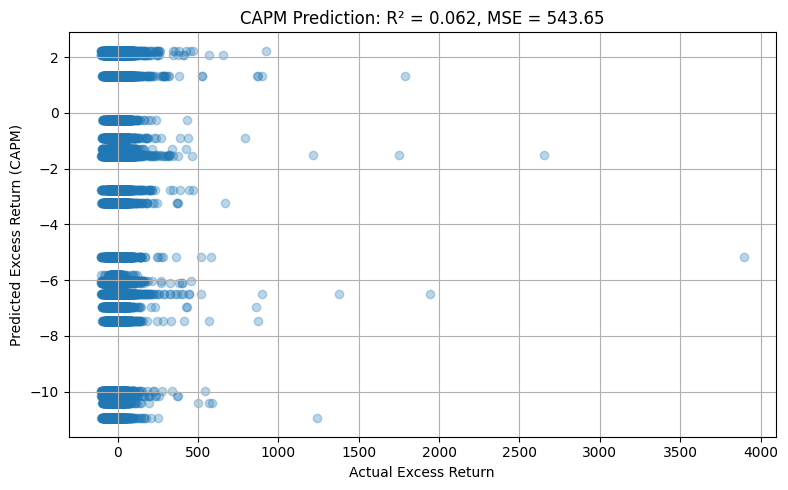

In [59]:
# capm plots 
# CAPM-style regression using just market excess return
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train/test split
X_capm = df_all_cols[["MarketExcessReturn"]].fillna(0)
y_capm = df_all_cols["ExcessReturn"]
X_capm_train, X_capm_test = X_capm.iloc[:int(0.8*len(X_capm))], X_capm.iloc[int(0.8*len(X_capm)):]
y_capm_train, y_capm_test = y_capm.iloc[:int(0.8*len(y_capm))], y_capm.iloc[int(0.8*len(y_capm)):]


capm_model = LinearRegression().fit(X_capm_train, y_capm_train)
y_capm_pred = capm_model.predict(X_capm_test)

# Add to results
results = []
capm_r2 = r2_oos(y_capm_test, y_capm_pred)
capm_mse = mean_squared_error(y_capm_test, y_capm_pred)
results.append({
    "Model": "CAPM (Market Excess Only)",
    "R2": capm_r2,
    "MSE": capm_mse
})

# Plot predicted vs actual
plt.figure(figsize=(8, 5))
plt.scatter(y_capm_test, y_capm_pred, alpha=0.3)
plt.xlabel("Actual Excess Return")
plt.ylabel("Predicted Excess Return (CAPM)")
plt.title(f"CAPM Prediction: R² = {capm_r2:.3f}, MSE = {capm_mse:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()


predictor_columns_v1 size 116
cutoff_date is 2023-04-01 00:00:00 Trainining Data would be split by < cutoff_date Test data >= cutoff_date
splitDataSetAndRunModelsForGivenPredictors predictor_columns size 116 X_train cols sizze 116
X_train data date range: 2015-04-01 00:00:00 → 2023-03-01 00:00:00
X_test data date range: 2023-04-01 00:00:00 → 2024-12-01 00:00:00
running models {'Linear Regression No PCA': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  slice(0, 115, None))])),
                ('linearregression', LinearRegression())]), 'Linear Regression With PCA': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler',
                                                  MinMaxScaler(fea

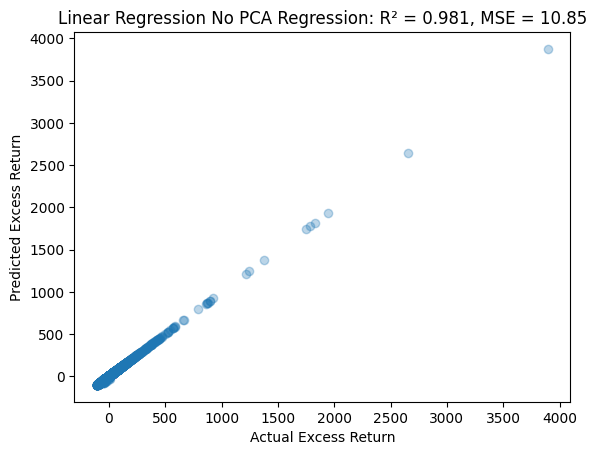


=== Training model Linear Regression With PCA ===
Finished training model Linear Regression With PCA in 4.11 seconds

Top features for Linear Regression With PCA:
top_features    feature  importance  abs_importance
12    PC13  -17.450075       17.450075
9     PC10   16.357504       16.357504
8      PC9   -9.625345        9.625345
13    PC14    5.117850        5.117850
14    PC15    1.998495        1.998495

Linear Regression With PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= Linear Regression With PCA, r2_score= 0.08932166194564228, mean_squared_error=530.2244350712177, run_time=4.105292081832886 


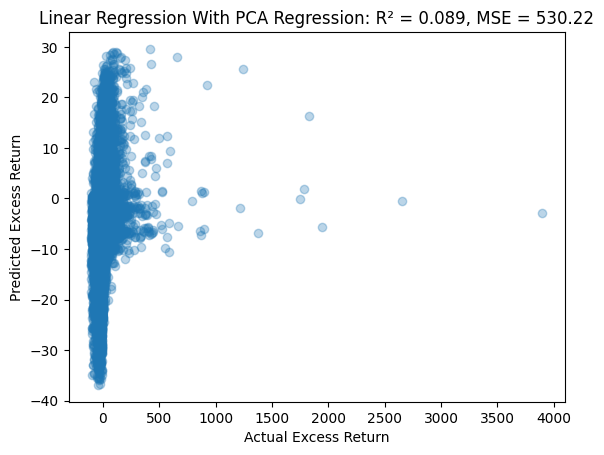


=== Training model ridge no pca ===
Finished training model ridge no pca in 5.27 seconds

Top features for ridge no pca:
top_features                   feature  importance
3                  High52    9.761048
5               IdioVol3F    6.699282
94                    cfp    6.136543
35                 IntMom    5.774919
17                 VolMkt    5.647276
65                   dNoa    5.427472
105  MomOffSeason06YrPlus    4.846701
56                 DelCOL    3.029384
78                  BMdec    2.946098
55               Accruals    2.870589

ridge no pca Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= ridge no pca, r2_score= 0.9818658784039512, mean_squared_error=10.55823332673121, run_time=5.270651817321777 


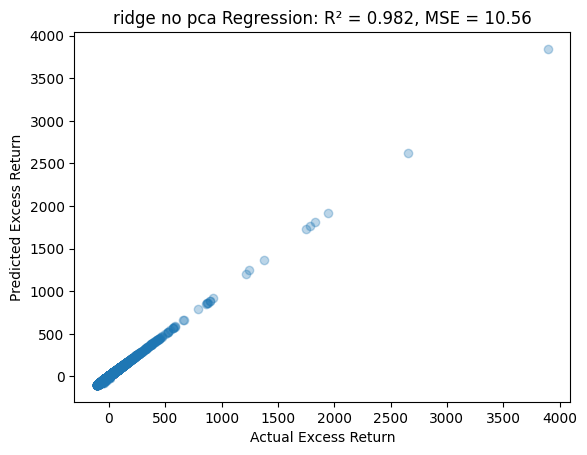


=== Training model ridge with PCA ===
Finished training model ridge with PCA in 3.84 seconds

Top features for ridge with PCA:
top_features    feature  importance  abs_importance
12    PC13  -17.449689       17.449689
9     PC10   16.357267       16.357267
8      PC9   -9.625214        9.625214
13    PC14    5.117730        5.117730
14    PC15    1.998437        1.998437

ridge with PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= ridge with PCA, r2_score= 0.08932146150905207, mean_squared_error=530.2245517714546, run_time=3.8377130031585693 


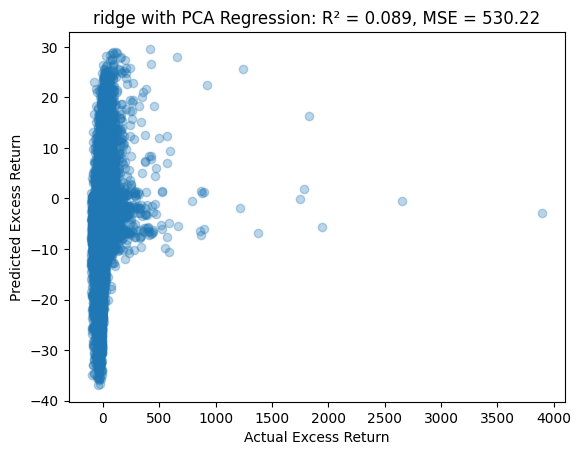


=== Training model lasso no pca ===
Finished training model lasso no pca in 5.18 seconds

Top features for lasso no pca:
top_features                 feature  importance
114  MarketExcessReturn    1.870486
21            CoskewACX    0.973179
28               IndMom    0.696134
25               IndIPO    0.008161
15          zerotrade6M   -0.000000
5             IdioVol3F   -0.000000
4           RealizedVol   -0.000000
10               DolVol   -0.000000
9           zerotrade1M    0.000000
12      PriceDelaySlope    0.000000

lasso no pca Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= lasso no pca, r2_score= 0.9777435366309556, mean_squared_error=12.95838522056778, run_time=5.1828672885894775 


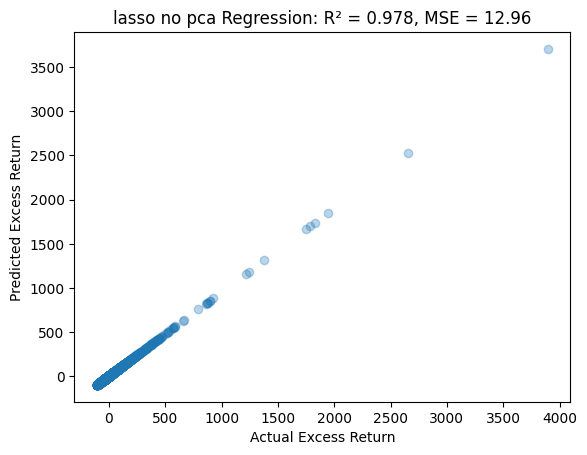


=== Training model lasso with PCA ===
Finished training model lasso with PCA in 3.92 seconds

Top features for lasso with PCA:
top_features    feature  importance  abs_importance
12    PC13  -17.275039       17.275039
9     PC10   16.242894       16.242894
8      PC9   -9.517840        9.517840
13    PC14    4.932405        4.932405
14    PC15    1.772304        1.772304

lasso with PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= lasso with PCA, r2_score= 0.08902870670493879, mean_squared_error=530.395002460945, run_time=3.918907880783081 


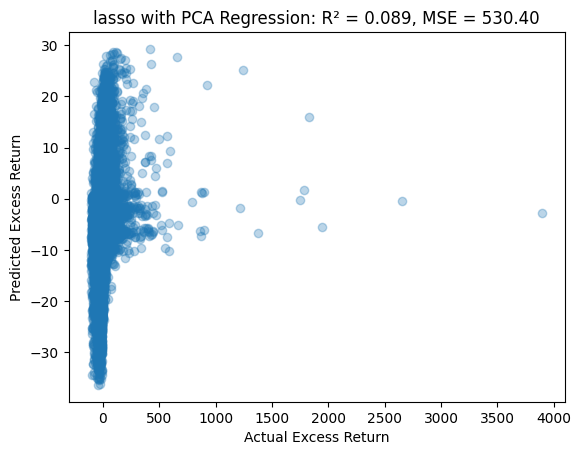


=== Training model elastic ===
Finished training model elastic in 3.82 seconds

Top features for elastic:
top_features    feature  importance  abs_importance
12    PC13  -15.965308       15.965308
9     PC10   15.416747       15.416747
8      PC9   -9.083343        9.083343
13    PC14    4.598724        4.598724
14    PC15    1.693834        1.693834

elastic Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= elastic, r2_score= 0.0881779049851158, mean_squared_error=530.8903649203339, run_time=3.8199658393859863 


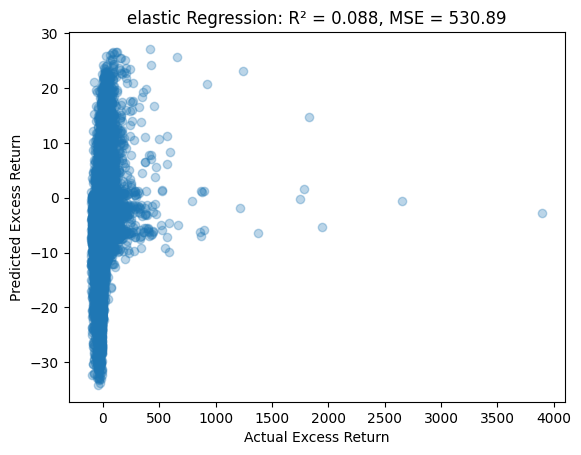


=== Training model xgb ===
Finished training model xgb in 6.08 seconds

Top features for xgb:
top_features    feature  importance  abs_importance
9     PC10    0.206067        0.206067
12    PC13    0.167992        0.167992
8      PC9    0.110617        0.110617
5      PC6    0.058283        0.058283
2      PC3    0.057277        0.057277

xgb Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=115, model_name= xgb, r2_score= 0.09778728691910443, mean_squared_error=525.2954925110282, run_time=6.082916259765625 


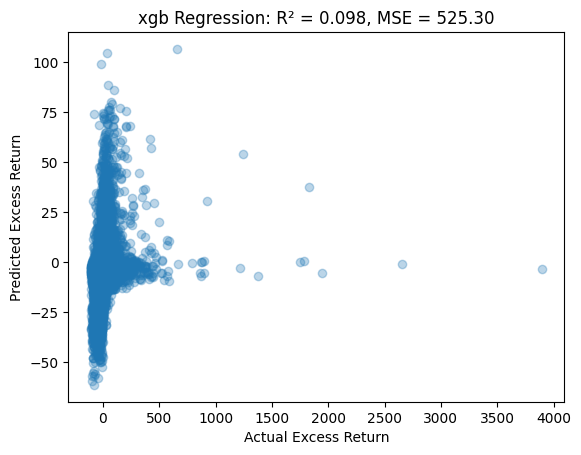

In [60]:
# Define evaluation metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline  
from sklearn.model_selection import train_test_split
import time

def prepare_models_pipeline(num_feature_cols):
# Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', MinMaxScaler(feature_range=(-1, 1)), slice(0, num_feature_cols))
        ]
    )

    num_components = 17

    # 1. Linear Regression Pipeline
    lr_pipeline_no_pca = make_pipeline(preprocessor, LinearRegression())
    lr_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), LinearRegression())

    ### 2. Ridge Regression (Regularization)
    
    ridge_pipeline_no_pca = make_pipeline(preprocessor, Ridge(alpha=1.0))
    ridge_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), Ridge(alpha=1.0))


    ### 3. Lasso Regression (Feature Selection)

    lasso_pipeline_no_pca = make_pipeline(preprocessor, Lasso(alpha=0.01))
    lasso_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), Lasso(alpha=0.01))

    ### 4. Random Forest (Nonlinear)
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))

    ### 5. XGBoost (Boosting)

    xgb_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))

    ### 6. Elastic Net
    elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
    elastic_pipeline = make_pipeline(preprocessor, PCA(n_components=num_components), elastic_net_model)

    # Train all models
    models = {
        'Linear Regression No PCA': lr_pipeline_no_pca,
        'Linear Regression With PCA': lr_pipeline,
        'ridge no pca': ridge_pipeline_no_pca,
        'ridge with PCA': ridge_pipeline,
        'lasso no pca': lasso_pipeline_no_pca,
        'lasso with PCA': lasso_pipeline,
        'elastic': elastic_pipeline,
        #'random forest': rf_pipeline,
        'xgb': xgb_pipeline
    }
    return models

from dataclasses import dataclass, asdict
from typing import Any, Optional

@dataclass
class ModelEvaluationMetric:
    run_description: Optional[str] = None
    model_name: Optional[str] = None
    r2_score: Optional[float] = None
    mean_squared_error: Optional[float] = None
    features_set: Optional[Any] = None
    run_time: Optional[float] = None
    Y_test: Optional[Any] = None
    y_pred: Optional[Any] = None

    def __str__(self):
     return f'run_description= {self.run_description}, features_set_size={len(self.features_set)}, model_name= {self.model_name}, r2_score= {self.r2_score}, mean_squared_error={self.mean_squared_error}, run_time={self.run_time} '

def plotTestAndPredictedData(title, Y_test, y_pred):
    plt.scatter(Y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Excess Return")
    plt.ylabel("Predicted Excess Return")
    plt.title(title)
    plt.show()


def generate_scatter_plot(title, y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, alpha=0.4, color='royalblue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Actual Excess Return")
    ax.set_ylabel("Predicted Excess Return")
    fig.tight_layout()
    return fig


def train_models(run_description, models, X_train, X_test, Y_train, Y_test):
    modelMetricsDict = {}
    print(f'running models {models}')
    plots = []
    for name, model in models.items():
        print(f"\n=== Training model {name} ===")
        start_time = time.time()
        model.fit(X_train, Y_train)
        elapsed_time = time.time() - start_time
        print(f'Finished training model {name} in {elapsed_time:.2f} seconds')
        print(f"\nTop features for {name}:")
        #top_features = get_top_features(model, name, feature_names, X_train)
        top_features = get_top_features_v2(model, X_train)
        print(f"top_features {top_features}")

        # Predictions
        y_pred = model.predict(X_test)
        
        # Evaluation
        print(f"\n{name} Evaluation:")
        # compare predictions y_pred with real test values Y_test

        r2_scor = r2_oos(Y_test, y_pred)
        mse = mean_squared_error(Y_test, y_pred)
        modelMetrics = ModelEvaluationMetric(run_description, name, r2_scor, mse, X_train.columns.tolist(), elapsed_time, Y_test, y_pred)
        print(f'modelMetrics {modelMetrics}')
        plot_title = f"{name} Regression: R² = {r2_scor:.3f}, MSE = {mse:.2f}"
        plotTestAndPredictedData(plot_title, Y_test, y_pred)
        modelMetricsDict[name] = modelMetrics
        
    return (run_description, modelMetricsDict, models, top_features)
   
 
# Run models with all features
predictor_columns_v1 = [col for col in df_all_cols.columns if col not in ['permno', 'ret', 'prc', 'Price', 'ExcessReturn', 'RiskFree', 'MarketReturn']]
print(f'predictor_columns_v1 size {len(predictor_columns_v1)}')
#X_train, X_test, Y_train, Y_test = splitDataFrameByDateToXAndY(df_all_cols, 0.8, predictor_columns_v1,  'ExcessReturn')


def splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns, df_data):
    X_train, X_test, Y_train, Y_test = splitDataFrameByDateToXAndY(df_data, 0.8, predictor_columns,  'ExcessReturn')
    print(f"splitDataSetAndRunModelsForGivenPredictors predictor_columns size {len(predictor_columns)} X_train cols sizze {len(X_train.columns)}")
    print("X_train data date range:", X_train['date'].min(), "→", X_train['date'].max())
    print("X_test data date range:", X_test['date'].min(), "→", X_test['date'].max())
    # drop the date column before running models
    if 'date' in X_train.columns:
        X_train.drop(columns=['date'], inplace=True)
    if 'date' in X_test.columns:
        X_test.drop(columns=['date'], inplace=True)
    models = prepare_models_pipeline(X_train.shape[1])
    v1_all_features_training = train_models('Run with All Features included ', models, X_train, X_test, Y_train, Y_test)
    return {
        'run_description': v1_all_features_training[0],
        'trained_models_metrics': v1_all_features_training[1],
        'top_features': v1_all_features_training[3], 
        'trained_models': v1_all_features_training[2]
    }
    
trained_models_results_v1 = splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns_v1, df_all_cols)


In [33]:
models_metrics = trained_models_results_v1['trained_models_metrics']
models_metrics

{'Linear Regression No PCA': ModelEvaluationMetric(run_description='Run with All Features included ', model_name='Linear Regression No PCA', r2_score=np.float64(0.9246581176479977), mean_squared_error=24.104267856462087, features_set=['Size', 'STreversal', 'MaxRet', 'High52', 'RealizedVol', 'IdioVol3F', 'ReturnSkew3F', 'ReturnSkew', 'IdioVolAHT', 'zerotrade1M', 'DolVol', 'PriceDelayRsq', 'PriceDelaySlope', 'Coskewness', 'PriceDelayTstat', 'zerotrade6M', 'BidAskSpread', 'VolMkt', 'zerotrade12M', 'Beta', 'Illiquidity', 'CoskewACX', 'DivInit', 'DivOmit', 'ExchSwitch', 'IndIPO', 'Spinoff', 'FirmAge', 'IndMom', 'Mom6m', 'VolSD', 'Mom12mOffSeason', 'BetaFP', 'MomSeasonShort', 'Mom12m', 'IntMom', 'VolumeTrend', 'ConvDebt', 'RDIPO', 'ShareRepurchase', 'OPLeverage', 'BookLeverage', 'RoE', 'MRreversal', 'ShareIss1Y', 'hire', 'betaVIX', 'ResidualMomentum', 'MomSeason', 'MomOffSeason', 'BetaLiquidityPS', 'ChInv', 'DelCOA', 'DelLTI', 'AssetGrowth', 'Accruals', 'DelCOL', 'ChNWC', 'DelFINL', 'DelNetF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# 1. Convert predicted and actual to log returns
log_return_actual = np.log1p(y_test.reset_index(drop=True))
log_return_predicted = np.log1p(pd.Series(y_pred).reset_index(drop=True))

# 2. Compute cumulative log returns
cum_log_return_actual = log_return_actual.cumsum()
cum_log_return_predicted = log_return_predicted.cumsum()

# 3. Plot
plt.figure(figsize=(10, 5))
plt.plot(cum_log_return_actual, label='Actual')
plt.plot(cum_log_return_predicted, label='Predicted (Model)', linestyle='--')
plt.title("Cumulative Log Returns Over Time")
plt.xlabel("Time Index")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


models_metrics = trained_models_results_v1['trained_models_metrics'].items()


fig, axes = plt.subplots(nrows=len(models_metrics), ncols=2, 
                         figsize=(10, 5*len(models_metrics)))
axes = axes.flatten()
ax0 = axes[0]
ax0.scatter(y_capm_test, y_capm_pred, alpha=0.3, color='royalblue')
ax0.set_title(f"CAPM Prediction: R² = {capm_r2:.3f}, MSE = {capm_mse:.2f}", fontsize=12)
ax0.set_xlabel("Actual Excess Return")
ax0.set_ylabel("Predicted Excess Return (CAPM)")

for i, col in enumerate(models_metrics):
    ax = axes[i+1]
    Y_test = col[1].Y_test
    y_pred = col[1].y_pred
    log_return_actual = np.log1p(Y_test.reset_index(drop=True))
    log_return_predicted = np.log1p(pd.Series(y_pred).reset_index(drop=True))
    cum_log_return_actual = log_return_actual.cumsum()
    cum_log_return_predicted = log_return_predicted.cumsum()
    ax.scatter(Y_test, y_pred, alpha=0.3, color='royalblue')
    
    
    #ax.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--')
    #axes[i,0].axvline(df_cleaned[col].mean(), color='red', linestyle='--', label='Mean')
    #axes[i,0].axvline(df_cleaned[col].median(), color='green', linestyle='-.', label='Median')
    plot_title = f"{col[1].model_name}: R² = {col[1].r2_score:.3f}, MSE = {col[1].mean_squared_error:.2f}"
    ax.set_title(plot_title, fontsize=12)
    ax.set_xlabel("Actual Excess Return")
    ax.set_ylabel("Predicted Excess Return")
    ax.legend()
    # Turn off any unused axes

plt.tight_layout()
plt.show()

/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_82008/3756568461.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


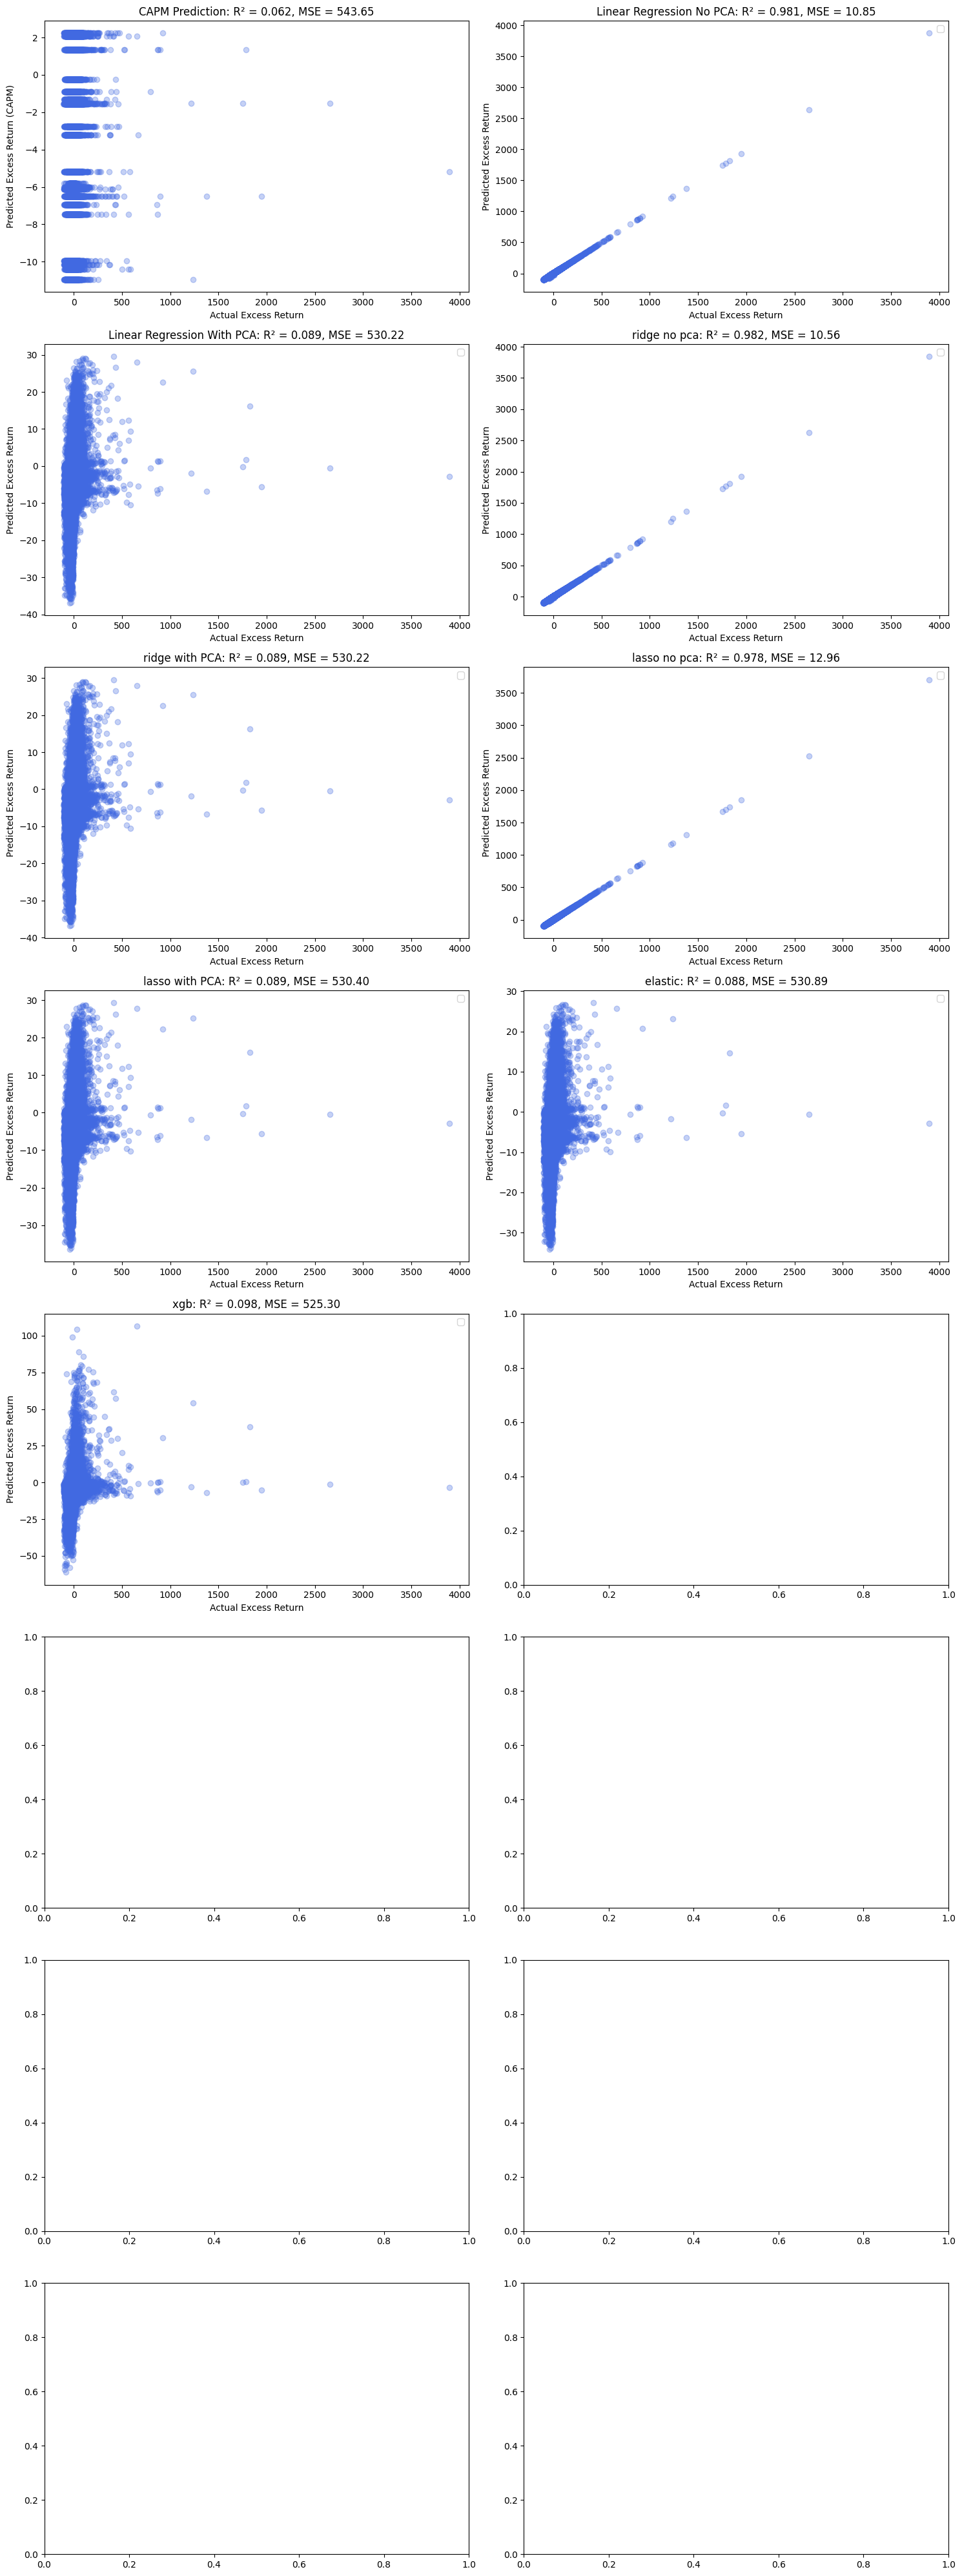

In [61]:
models_metrics = trained_models_results_v1['trained_models_metrics'].items()


fig, axes = plt.subplots(nrows=len(models_metrics), ncols=2, 
                         figsize=(15, 5*len(models_metrics)))
axes = axes.flatten()
ax0 = axes[0]
ax0.scatter(y_capm_test, y_capm_pred, alpha=0.3, color='royalblue')
ax0.set_title(f"CAPM Prediction: R² = {capm_r2:.3f}, MSE = {capm_mse:.2f}", fontsize=12)
ax0.set_xlabel("Actual Excess Return")
ax0.set_ylabel("Predicted Excess Return (CAPM)")

for i, col in enumerate(models_metrics):
    ax = axes[i+1]
    Y_test = col[1].Y_test
    ax.scatter(Y_test, col[1].y_pred, alpha=0.3, color='royalblue')
    #ax.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--')
    #axes[i,0].axvline(df_cleaned[col].mean(), color='red', linestyle='--', label='Mean')
    #axes[i,0].axvline(df_cleaned[col].median(), color='green', linestyle='-.', label='Median')
    plot_title = f"{col[1].model_name}: R² = {col[1].r2_score:.3f}, MSE = {col[1].mean_squared_error:.2f}"
    ax.set_title(plot_title, fontsize=12)
    ax.set_xlabel("Actual Excess Return")
    ax.set_ylabel("Predicted Excess Return")
    ax.legend()
    # Turn off any unused axes

plt.tight_layout()
plt.show()

### 📊 Linear Regression Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** Linear Regression  
**R² Score:** 0.8150  
**Mean Squared Error:** 62.6735  
**Run Time:** 69.72 seconds  

---

### 🔧 ridge Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** ridge  
**R² Score:** 0.7934  
**Mean Squared Error:** 69.9769  
**Run Time:** 23.88 seconds  

---

### 🔧 lasso Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** lasso  
**R² Score:** 0.9800  
**Mean Squared Error:** 6.7633  
**Run Time:** 79.40 seconds  

---

### ⚡ xgb Evaluation
**Run Description:** Run with All Features included  
**Feature Set Size:** 114  
**Model Name:** xgb  
**R² Score:** 0.7631  
**Mean Squared Error:** 80.2573  
**Run Time:** 57.40 seconds  


In [35]:
def printTrainedModelMetrics(trained_models_metrics):
    table = [{k:v for k,v in asdict(r).items() if k != 'features_set'} for r in trained_models_metrics.values()]
    print(tabulate(table, headers="keys", floatfmt=".4f", tablefmt="grid"))
    

### First attempt results

+--------------------------------+-------------------+------------+----------------------+------------+
| run_description                | model_name        |   r2_score |   mean_squared_error |   run_time |
+================================+===================+============+======================+============+
| Run with All Features included | Linear Regression |     0.8150 |              62.6735 |    69.7220 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | ridge             |     0.7934 |              69.9769 |    23.8810 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | lasso             |     0.9800 |               6.7633 |    79.3975 |
+--------------------------------+-------------------+------------+----------------------+------------+
| Run with All Features included | xgb               |     0.7631 |              80.2573 |    57.3993 |
+--------------------------------+-------------------+------------+----------------------+------------+

# Likely Data Leakage

following features in your predictive models — they may contain information from the **future**, leading to **data leakage** and artificially high performance.

## 🧨 Feature Risk Table

| **Feature**             | **Why It's Risky** |
|-------------------------|--------------------|
| `AnnouncementReturn`    | Could include post-earnings announcement movement, which is only known after the fact. |
| `NumEarnIncrease`       | May be calculated over a future window of earnings, not just past — check the window. |
| `EarningsSurprise`      | ⚠️ Classic look-ahead: often uses actual earnings vs expected, which isn’t known until after quarter end. |
| `NetEquityFinance`      | Can contain forward-looking aggregated data if not lagged properly. |
| `NetDebtFinance`        | Same as above — check that it's lagged correctly. |
| `ShareIss5Y`            | May include data that isn’t known until well after the time of prediction. |
| `DebtIssuance`          | May reflect corporate actions announced or occurring after t — check time alignment. |
| `EquityDuration`        | Same as above — ensure it only uses data available at time t. |
| `ShareRepurchase`       | Can include forward-looking repurchase behavior — validate the time frame. |
| `BetaTailRisk`          | If calculated using forward return vol/skew, this leaks performance — use historical windows only. |
| `BetaLiquidityPS`       | Same as above — avoid forward-looking volatility-based calculations. |
| `betaVIX`               | Ensure it's not forward-looking — only use past data if available. |

---

## ✅ Tips to Avoid Leakage

- Always check **calculation windows** — are they backward-looking?
- Ensure that features don’t use any information that wouldn’t be available **at prediction time**.
- When in doubt, **lag** or drop the feature.

---

📌 *Want to add automated checks for leakage or build a pipeline that enforces time alignment? Let me know!*


True
True
predictor_columns_v2 size 112
cutoff_date is 2011-11-01 00:00:00 Trainining Data would be split by < cutoff_date Test data >= cutoff_date
splitDataSetAndRunModelsForGivenPredictors predictor_columns size 112 X_train cols sizze 112
X_train data date range: 1960-01-01 00:00:00 → 2011-10-01 00:00:00
X_test data date range: 2011-11-01 00:00:00 → 2024-12-01 00:00:00
running models {'Linear Regression No PCA': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  slice(0, 111, None))])),
                ('linearregression', LinearRegression())]), 'Linear Regression With PCA': Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler',
                                                  MinMax

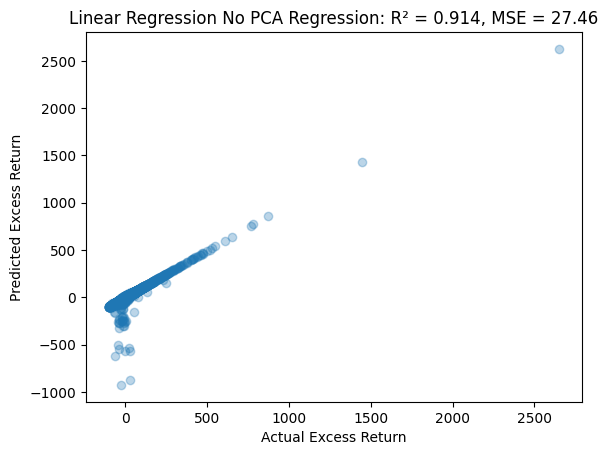


=== Training model Linear Regression With PCA ===
Finished training model Linear Regression With PCA in 4.05 seconds

Top features for Linear Regression With PCA:
top_features    feature  importance  abs_importance
9     PC10  -21.960567       21.960567
15    PC16   15.160466       15.160466
10    PC11   -2.610370        2.610370
16    PC17   -2.592871        2.592871
14    PC15   -2.179948        2.179948

Linear Regression With PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= Linear Regression With PCA, r2_score= 0.1430607915513512, mean_squared_error=274.16214690051305, run_time=4.0542519092559814 


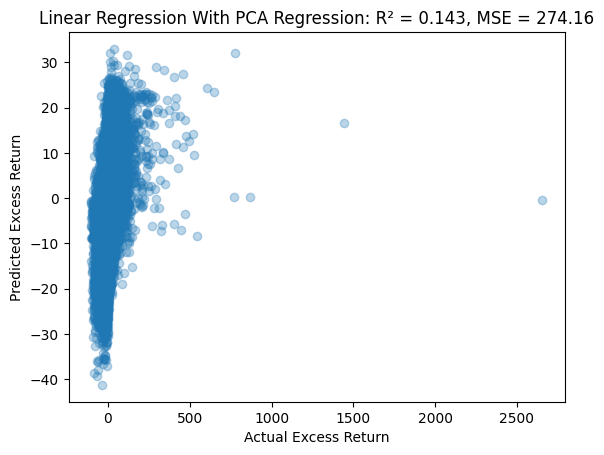


=== Training model ridge no pca ===
Finished training model ridge no pca in 4.40 seconds

Top features for ridge no pca:
top_features                 feature  importance
6            IdioVolAHT    5.672311
18          Illiquidity    5.664360
61                  NOA    5.532847
2                High52    5.441938
110  MarketExcessReturn    5.320587
66        TotalAccruals    4.796473
105           PctTotAcc    4.532316
52          AssetGrowth    4.373248
8                DolVol    4.178547
104          Investment    3.306976

ridge no pca Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= ridge no pca, r2_score= 0.9158410224071956, mean_squared_error=26.9251374546927, run_time=4.395532131195068 


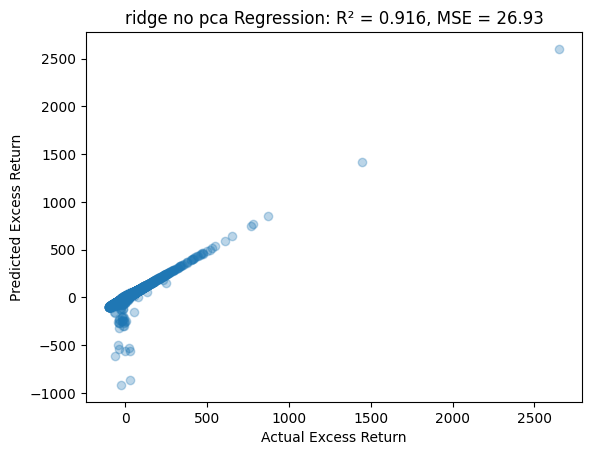


=== Training model ridge with PCA ===
Finished training model ridge with PCA in 3.66 seconds

Top features for ridge with PCA:
top_features    feature  importance  abs_importance
9     PC10  -21.960250       21.960250
15    PC16   15.160084       15.160084
10    PC11   -2.610331        2.610331
16    PC17   -2.592804        2.592804
14    PC15   -2.179899        2.179899

ridge with PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= ridge with PCA, r2_score= 0.14306036827640412, mean_squared_error=274.1622823196502, run_time=3.660125255584717 


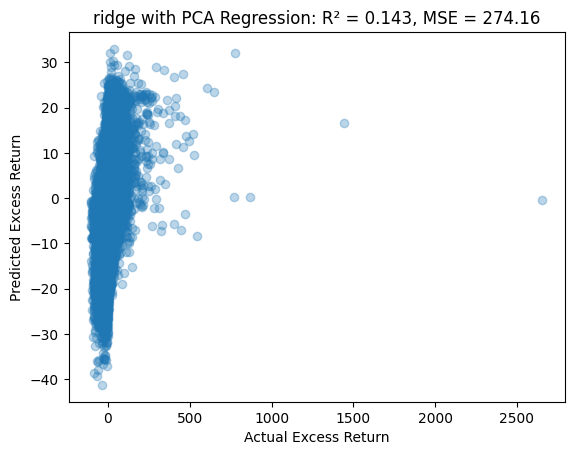


=== Training model lasso no pca ===
Finished training model lasso no pca in 13.35 seconds

Top features for lasso no pca:
top_features                 feature  importance
110  MarketExcessReturn    5.842349
8                DolVol    3.146206
85                   BM    0.754846
23               IndIPO    0.107118
20              DivInit    0.082140
30               BetaFP    0.068140
10      PriceDelaySlope    0.000000
17                 Beta    0.000000
18          Illiquidity   -0.000000
19            CoskewACX    0.000000

lasso no pca Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= lasso no pca, r2_score= 0.9848703493023082, mean_squared_error=4.840457148230229, run_time=13.349839210510254 


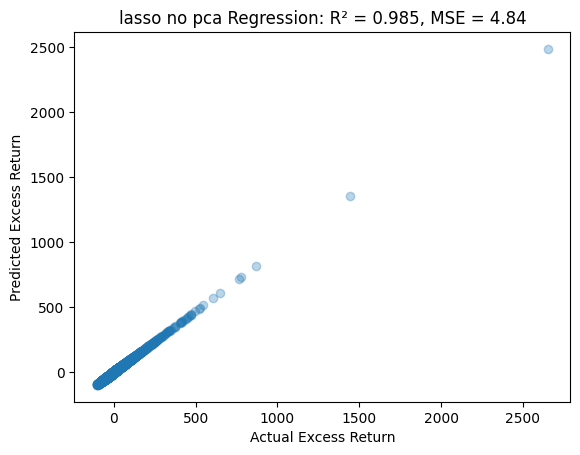


=== Training model lasso with PCA ===
Finished training model lasso with PCA in 4.28 seconds

Top features for lasso with PCA:
top_features    feature  importance  abs_importance
9     PC10  -21.845203       21.845203
15    PC16   14.959411       14.959411
10    PC11   -2.489728        2.489728
16    PC17   -2.385289        2.385289
14    PC15   -1.998330        1.998330

lasso with PCA Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= lasso with PCA, r2_score= 0.14288711478255056, mean_squared_error=274.21771163057986, run_time=4.275183200836182 


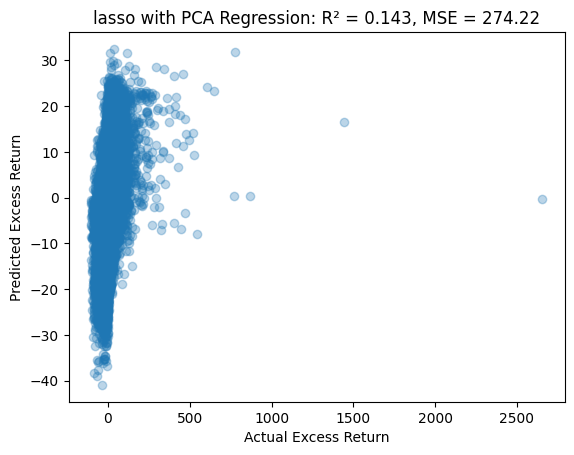


=== Training model elastic ===
Finished training model elastic in 3.86 seconds

Top features for elastic:
top_features    feature  importance  abs_importance
9     PC10  -20.708382       20.708382
15    PC16   13.684295       13.684295
10    PC11   -2.404978        2.404978
16    PC17   -2.255029        2.255029
14    PC15   -1.915219        1.915219

elastic Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= elastic, r2_score= 0.14085207509352293, mean_squared_error=274.86878564454827, run_time=3.8638570308685303 


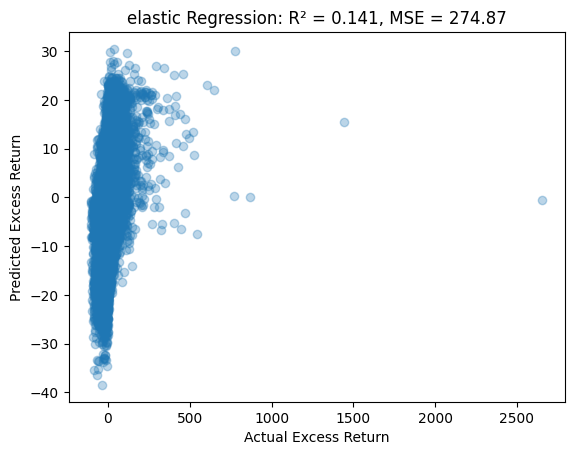


=== Training model xgb ===
Finished training model xgb in 6.07 seconds

Top features for xgb:
top_features    feature  importance  abs_importance
9     PC10    0.392367        0.392367
15    PC16    0.134581        0.134581
16    PC17    0.066789        0.066789
4      PC5    0.051898        0.051898
6      PC7    0.048909        0.048909

xgb Evaluation:
modelMetrics run_description= Run with All Features included , features_set_size=111, model_name= xgb, r2_score= 0.17721351017372333, mean_squared_error=263.235604425056, run_time=6.070029973983765 


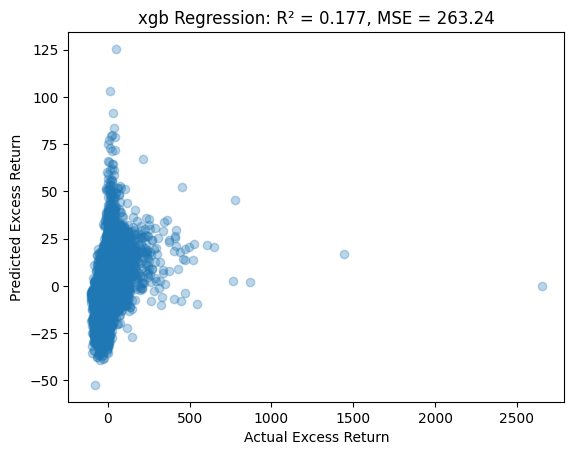

+--------------------------------+----------------------------+------------+----------------------+------------+----------------------------------------------------+-------------------------------------------------------------------------+
| run_description                | model_name                 |   r2_score |   mean_squared_error |   run_time | Y_test                                             | y_pred                                                                  |
+================================+============================+============+======================+============+====================================================+=========================================================================+
| Run with All Features included | Linear Regression No PCA   |     0.9142 |              27.4574 |    10.1632 | 799239    -8.5271                                  | [-11.11184063  -3.15237934  -1.43897141 ...  -6.16371584  -5.14656709   |
|                                |      

In [36]:
# 🔍 A. Check correlation of EBM/BPEBM with target

df_all_cols[['EBM', 'BPEBM', 'ExcessReturn']].corr()
print('EBM' in predictor_columns_v1)
print('BPEBM' in predictor_columns_v1)


# If correlation > 0.9 — they might be leaky or overly dominant
REMOVE_PREDICTORS_V1 = ['EBM', 'BPEBM',  'IdioVol3F', 'MaxRet']

predictor_columns_v2 = [p for p in predictor_columns_v1 if p not in REMOVE_PREDICTORS_V1]

print(f"predictor_columns_v2 size {len(predictor_columns_v2)}")
trained_models_results = splitDataSetAndRunModelsForGivenPredictorsAndGetResults(predictor_columns_v2, df_all_cols)
printTrainedModelMetrics(trained_models_results['trained_models_metrics'])



Top predictive features:
 EarnSupBig          1.094582e-14
ChInvIA            -9.856444e-17
EarningsSurprise    3.499706e-17
dtype: float64